Author: Pushkar Patel

# Task 2 Part 2

Imports

In [48]:
import shutil
from PIL import Image
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

## Preprocessing the image

Extracting the images

In [4]:
shutil.unpack_archive('trainPart1.zip', 'input/part2')

Delete all other samples except images from 0-9

In [5]:
for i in range(11, 63):
    shutil.rmtree(f'input/part2/train/Sample0{i}')

## Generating the dataset for pre-training

As with part 1 of this task, I'm converting all the images to the dimension of the MNIST images by first resizing the largest dimension to 28 and then zer-padding them to make it a square. The background in the MNIST dtaset have 0 value so, I'm inverting our daatset images to make it similar to MNIST


Some global variables

In [6]:
BATCH_SIZE = 64
IMAGE_SIZE_BEFORE_PADDING = (21, 28)
EPOCHS = 400
IMAGE_SIZE = (28, 28)

Using ImageDataGenerator to generate the samples form the dataset

In [43]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, preprocessing_function=lambda x: 1-x)

Found 320 images belonging to 10 classes.
Found 80 images belonging to 10 classes.
(64, 21, 28, 1) (64, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


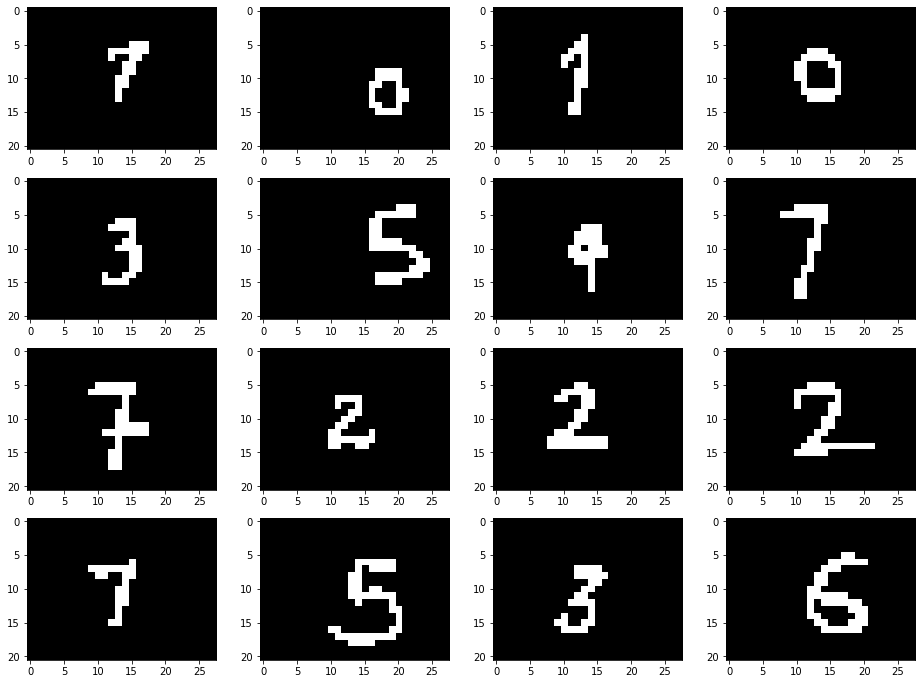

In [44]:
train_generator = train_datagen.flow_from_directory(
    'input/part2/train',
    target_size=IMAGE_SIZE_BEFORE_PADDING,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training',
    seed=42,
    shuffle=True)

validation_generator = train_datagen.flow_from_directory(
    'input/part2/train',
    target_size=IMAGE_SIZE_BEFORE_PADDING,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation',
    seed=42,
    shuffle=True)

X_train_batch0, y_train_batch0 = train_generator.next()
print(X_train_batch0.shape, y_train_batch0.shape)
print(y_train_batch0[0])
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_train_batch0[i]), cmap='gray')
plt.show()

## Loading the MNIST Dataset

(60000, 28, 28, 1) (60000, 10)
(10000, 28, 28, 1) (10000, 10)


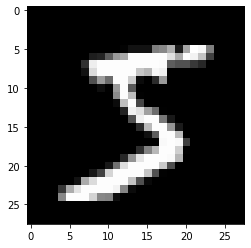

In [58]:
(x_train, y_train), (x_test, y_test) = mnist.load_data(path="mnist.npz")
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)


print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
imshow(tf.squeeze(x_train[0]), cmap='gray')

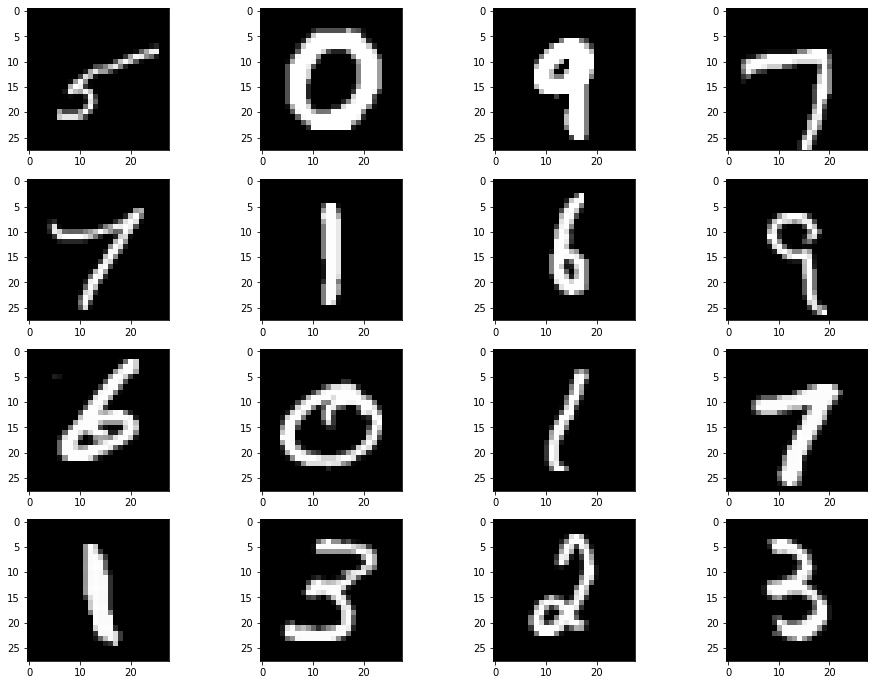

In [60]:
mnist_datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare an iterators to scale images
mnist_train_gen = mnist_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
mnist_test_gen = mnist_datagen.flow(x_test, y_test, batch_size=BATCH_SIZE)

mnist_x_train, _ = mnist_train_gen.next()
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(mnist_x_train[i]), cmap='gray')
plt.show()

## Building the Model

From my results from Part 1 of this task, Architecture from Kaggle and the original  performed good. I'll use them both with Mish Activation and higher temperature for the Softmax and see how both of them perform.

In [96]:
# Early Stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    restore_best_weights=True,
    verbose=1)

early_stopping_callback2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=50,
    restore_best_weights=True,
    verbose=1)

In [62]:
# Softmax Temperature
temp = 5

In [63]:
# Mish Activation function
def mish(x):
    return tf.keras.layers.Lambda(lambda x: x*tf.tanh(tf.math.log(1+tf.exp(x))))(x)

### Modified LeNet Architecture

#### Pre-training on our dataset

In [72]:
model1 = Sequential()

# Lambda Layer for adding Padding
model1.add(Lambda(lambda image: tf.image.resize_with_crop_or_pad(
        image, 28, 28), input_shape=(*IMAGE_SIZE_BEFORE_PADDING, 1)))

# 1st Convolution Layer
model1.add(Conv2D(6, input_shape=(*IMAGE_SIZE, 1),
                  kernel_size=(5,5), padding='same', activation=mish))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2), strides=2))

# 2nd Convolution Layer
model1.add(Conv2D(16, kernel_size=(5,5), activation=mish))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Passing to a Fully Connected Layer
model1.add(Flatten())

# 1st Fully Connected Layer
model1.add(Dense(120, activation=mish))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))

# 2nd Fully Connected Layer
model1.add(Dense(84, activation=mish))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))

# Output Layer
# Increasing the softmax temperature
model1.add(Lambda(lambda x: x / temp))
model1.add(Dense(10, activation='softmax'))

model1.summary()

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_18 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization_48 (Batc (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_49 (Batc (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 16)         

In [73]:
checkpoint_filepath1 = 'part2_pretrained/checkpoint'
model_checkpoint_callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history1 = model1.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback1, early_stopping_callback]
)

Epoch 1/400
5/5 [==============================] - 7s 1s/step - loss: 2.3350 - accuracy: 0.1408 - val_loss: 2.3025 - val_accuracy: 0.1250
Epoch 2/400
5/5 [==============================] - 5s 1s/step - loss: 2.1667 - accuracy: 0.1862 - val_loss: 2.3019 - val_accuracy: 0.1562
Epoch 3/400
5/5 [==============================] - 5s 1s/step - loss: 2.0587 - accuracy: 0.3332 - val_loss: 2.2992 - val_accuracy: 0.2500
Epoch 4/400
5/5 [==============================] - 5s 1s/step - loss: 1.9465 - accuracy: 0.4384 - val_loss: 2.3031 - val_accuracy: 0.0938
Epoch 5/400
5/5 [==============================] - 5s 1s/step - loss: 1.8744 - accuracy: 0.5266 - val_loss: 2.2950 - val_accuracy: 0.1250
Epoch 6/400
5/5 [==============================] - 5s 1s/step - loss: 1.7995 - accuracy: 0.5392 - val_loss: 2.2947 - val_accuracy: 0.0938
Epoch 7/400
5/5 [==============================] - 5s 1s/step - loss: 1.7303 - accuracy: 0.6256 - val_loss: 2.2930 - val_accuracy: 0.0938
Epoch 8/400
5/5 [=================

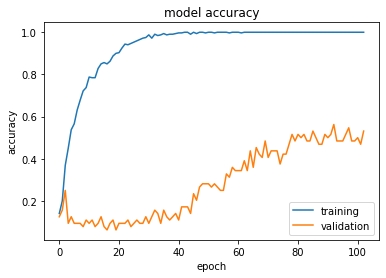

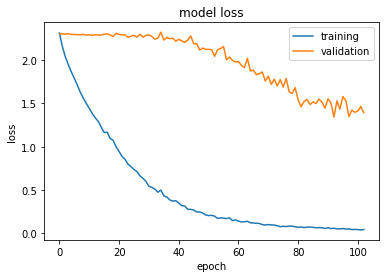

In [74]:
plt.figure(1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

plt.figure(2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

This is the expected performance, but it actually gives good results after some more epochs. I think this is becasue now we have lesst samples to train with (only numbers).

#### Training on MNIST with pre-trained weights

In [75]:
model1 = Sequential()

# Lambda Layer for adding Padding
model1.add(Lambda(lambda image: tf.image.resize_with_crop_or_pad(
        image, 28, 28), input_shape=(*IMAGE_SIZE_BEFORE_PADDING, 1)))

# 1st Convolution Layer
model1.add(Conv2D(6, input_shape=(*IMAGE_SIZE, 1),
                  kernel_size=(5,5), padding='same', activation=mish))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2), strides=2))

# 2nd Convolution Layer
model1.add(Conv2D(16, kernel_size=(5,5), activation=mish))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Passing to a Fully Connected Layer
model1.add(Flatten())

# 1st Fully Connected Layer
model1.add(Dense(120, activation=mish))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))

# 2nd Fully Connected Layer
model1.add(Dense(84, activation=mish))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))

# Output Layer
# Increasing the softmax temperature
model1.add(Lambda(lambda x: x / temp))
model1.add(Dense(10, activation='softmax'))

model1.summary()

model1.load_weights('part2_pretrained/checkpoint')

model1.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_20 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization_52 (Batc (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_53 (Batc (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 5, 5, 16)        

In [76]:
checkpoint_filepath1_after = 'part2_after_training/checkpoint'
model_checkpoint_callback1_after = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath1_after,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history1_after = model1.fit(
    mnist_train_gen,
    epochs=EPOCHS,
    validation_data=mnist_test_gen,
    steps_per_epoch = len(x_train) // BATCH_SIZE,
    validation_steps = len(x_test) // BATCH_SIZE,
    callbacks=[model_checkpoint_callback1_after, early_stopping_callback]
)

Epoch 1/400
937/937 [==============================] - 7s 7ms/step - loss: 0.3721 - accuracy: 0.8970 - val_loss: 0.0916 - val_accuracy: 0.9725
Epoch 2/400
937/937 [==============================] - 6s 6ms/step - loss: 0.0984 - accuracy: 0.9727 - val_loss: 0.0605 - val_accuracy: 0.9818
Epoch 3/400
937/937 [==============================] - 6s 6ms/step - loss: 0.0753 - accuracy: 0.9784 - val_loss: 0.0475 - val_accuracy: 0.9846
Epoch 4/400
937/937 [==============================] - 6s 6ms/step - loss: 0.0618 - accuracy: 0.9826 - val_loss: 0.0421 - val_accuracy: 0.9865
Epoch 5/400
937/937 [==============================] - 6s 6ms/step - loss: 0.0529 - accuracy: 0.9849 - val_loss: 0.0447 - val_accuracy: 0.9853
Epoch 6/400
937/937 [==============================] - 6s 6ms/step - loss: 0.0482 - accuracy: 0.9858 - val_loss: 0.0472 - val_accuracy: 0.9853
Epoch 7/400
937/937 [==============================] - 6s 6ms/step - loss: 0.0456 - accuracy: 0.9857 - val_loss: 0.0505 - val_accuracy: 0.9848

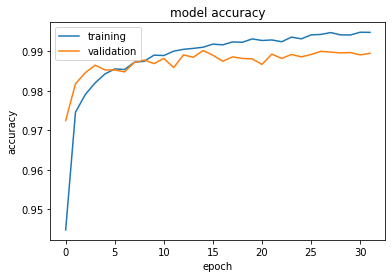

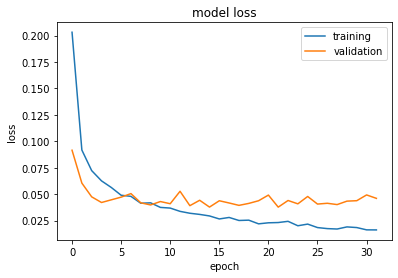

In [78]:
plt.figure(1)
plt.plot(history1_after.history['accuracy'])
plt.plot(history1_after.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

plt.figure(2)
plt.plot(history1_after.history['loss'])
plt.plot(history1_after.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

This performs really good on the MNIST dataset adn converges fast.

#### Untrained network with random initializations

In [81]:
model1 = Sequential()

# Lambda Layer for adding Padding
model1.add(Lambda(lambda image: tf.image.resize_with_crop_or_pad(
        image, 28, 28), input_shape=(*IMAGE_SIZE_BEFORE_PADDING, 1)))

# 1st Convolution Layer
model1.add(Conv2D(6, input_shape=(*IMAGE_SIZE, 1),
                  kernel_size=(5,5), padding='same', activation=mish))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2), strides=2))

# 2nd Convolution Layer
model1.add(Conv2D(16, kernel_size=(5,5), activation=mish))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Passing to a Fully Connected Layer
model1.add(Flatten())

# 1st Fully Connected Layer
model1.add(Dense(120, activation=mish))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))

# 2nd Fully Connected Layer
model1.add(Dense(84, activation=mish))
model1.add(BatchNormalization())
model1.add(Dropout(0.4))

# Output Layer
# Increasing the softmax temperature
model1.add(Lambda(lambda x: x / temp))
model1.add(Dense(10, activation='softmax'))

model1.summary()

model1.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_24 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization_60 (Batc (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_61 (Batc (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 5, 5, 16)        

In [82]:
checkpoint_filepath1_un = 'part2_untrained/checkpoint'
model_checkpoint_callback1_un = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath1_un,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history1_un = model1.fit(
    mnist_train_gen,
    epochs=EPOCHS,
    validation_data=mnist_test_gen,
    steps_per_epoch = len(x_train) // BATCH_SIZE,
    validation_steps = len(x_test) // BATCH_SIZE,
    callbacks=[model_checkpoint_callback1_un, early_stopping_callback]
)

Epoch 1/400
937/937 [==============================] - 7s 7ms/step - loss: 0.7657 - accuracy: 0.8426 - val_loss: 0.1065 - val_accuracy: 0.9671
Epoch 2/400
937/937 [==============================] - 6s 7ms/step - loss: 0.1026 - accuracy: 0.9714 - val_loss: 0.0564 - val_accuracy: 0.9821
Epoch 3/400
937/937 [==============================] - 6s 6ms/step - loss: 0.0768 - accuracy: 0.9788 - val_loss: 0.0495 - val_accuracy: 0.9848
Epoch 4/400
937/937 [==============================] - 6s 6ms/step - loss: 0.0648 - accuracy: 0.9809 - val_loss: 0.0486 - val_accuracy: 0.9849
Epoch 5/400
937/937 [==============================] - 6s 6ms/step - loss: 0.0569 - accuracy: 0.9834 - val_loss: 0.0466 - val_accuracy: 0.9854
Epoch 6/400
937/937 [==============================] - 6s 6ms/step - loss: 0.0544 - accuracy: 0.9834 - val_loss: 0.0490 - val_accuracy: 0.9854
Epoch 7/400
937/937 [==============================] - 6s 6ms/step - loss: 0.0533 - accuracy: 0.9844 - val_loss: 0.0476 - val_accuracy: 0.9858

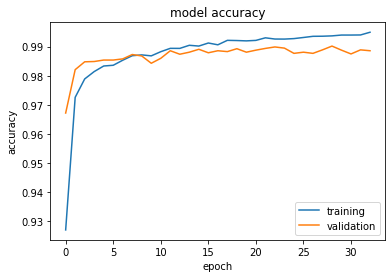

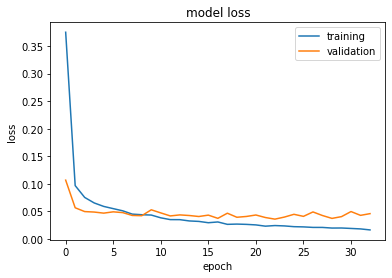

In [83]:
plt.figure(1)
plt.plot(history1_un.history['accuracy'])
plt.plot(history1_un.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

plt.figure(2)
plt.plot(history1_un.history['loss'])
plt.plot(history1_un.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

This has similar performance to that of the pretrained model. Let's compare the plots more closely.

#### Observations and results

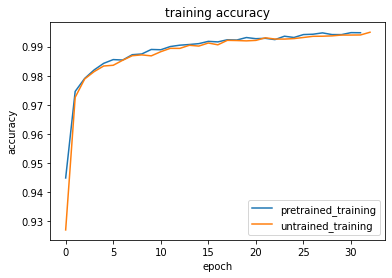

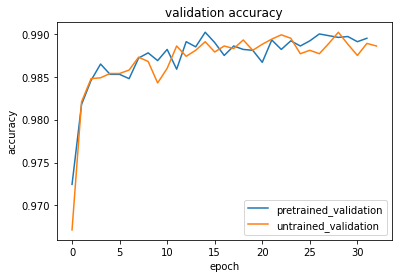

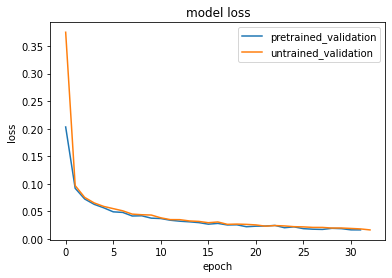

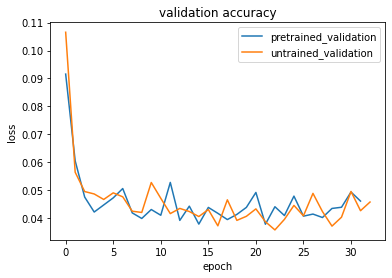

In [86]:
plt.figure(1)
plt.plot(history1_after.history['accuracy'])
plt.plot(history1_un.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['pretrained_training', 'untrained_training'], loc='best')
plt.show()

plt.figure(2)
plt.plot(history1_after.history['val_accuracy'])
plt.plot(history1_un.history['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['pretrained_validation', 'untrained_validation'], loc='best')
plt.show()

plt.figure(3)
plt.plot(history1_after.history['loss'])
plt.plot(history1_un.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['pretrained_validation', 'untrained_validation'], loc='best')
plt.show()

plt.figure(4)
plt.plot(history1_after.history['val_loss'])
plt.plot(history1_un.history['val_loss'])
plt.title('validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['pretrained_validation', 'untrained_validation'], loc='best')
plt.show()

We can see that although both the models perform at-par with each other, the pretrained model performs 'slightly' better. The reasons are:
- The pretrained accuracy for both the test and validation sets start higher than the randomly initialized models.
- During the training phase, the pretrained overall performs better.
- The same can be said for the loss, which starts lower for both the training and validation set for the pretrained model and for most part, stays lower.
- **Overall, the pre-trained network ahs higher final accuracy and lower final loss and also has converged faster**

### 2nd Architecture from Kaggle

#### Pre-training on our dataset

In [97]:
model2 = Sequential()

# Lambda Layer for adding Padding
model2.add(Lambda(lambda image: tf.image.resize_with_crop_or_pad(
        image, 28, 28), input_shape=(*IMAGE_SIZE_BEFORE_PADDING, 1)))

# 1st Convolution Layer
model2.add(Conv2D(32, input_shape=(*IMAGE_SIZE, 1), kernel_size=3, activation=mish))
model2.add(BatchNormalization())
model2.add(Conv2D(32, kernel_size=3, activation=mish))
model2.add(BatchNormalization())
model2.add(Conv2D(32, kernel_size=5, strides=2, padding='same', activation=mish))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

# 2nd Convolution Layer
model2.add(Conv2D(64, kernel_size=3, activation=mish))
model2.add(BatchNormalization())
model2.add(Conv2D(64, kernel_size=3, activation=mish))
model2.add(BatchNormalization())
model2.add(Conv2D(64, kernel_size=5, strides=2, padding='same', activation=mish))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

# 3rd Convolution Layer
model2.add(Conv2D(128, kernel_size = 4, activation=mish))
model2.add(BatchNormalization())

# Passing to a Fully Connected Layer
model2.add(Flatten())
model2.add(Dropout(0.4))

# Output Layer

# Increasing the softmax temperature
model2.add(Lambda(lambda x: x / temp))
model2.add(Dense(10, activation='softmax'))

model2.summary()

model2.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_32 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_85 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_86 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_87 (Batc (None, 12, 12, 32)      

In [98]:
checkpoint_filepath2 = 'part2_pretrained2/checkpoint'
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history2 = model2.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback2, early_stopping_callback2]
)

Epoch 1/400
5/5 [==============================] - 7s 1s/step - loss: 2.3138 - accuracy: 0.1182 - val_loss: 2.3023 - val_accuracy: 0.1250
Epoch 2/400
5/5 [==============================] - 5s 1s/step - loss: 2.1094 - accuracy: 0.2765 - val_loss: 2.3019 - val_accuracy: 0.1094
Epoch 3/400
5/5 [==============================] - 5s 1s/step - loss: 1.8971 - accuracy: 0.4526 - val_loss: 2.3014 - val_accuracy: 0.0938
Epoch 4/400
5/5 [==============================] - 5s 1s/step - loss: 1.7170 - accuracy: 0.5365 - val_loss: 2.2995 - val_accuracy: 0.1094
Epoch 5/400
5/5 [==============================] - 5s 1s/step - loss: 1.5864 - accuracy: 0.6230 - val_loss: 2.2963 - val_accuracy: 0.1094
Epoch 6/400
5/5 [==============================] - 5s 1s/step - loss: 1.4425 - accuracy: 0.6797 - val_loss: 2.3012 - val_accuracy: 0.1094
Epoch 7/400
5/5 [==============================] - 5s 1s/step - loss: 1.3561 - accuracy: 0.6646 - val_loss: 2.2970 - val_accuracy: 0.1250
Epoch 8/400
5/5 [=================

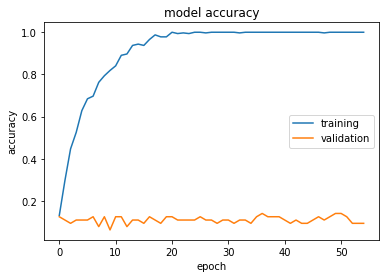

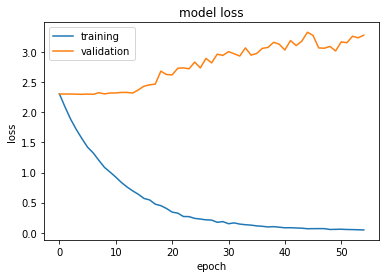

In [100]:
plt.figure(1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

plt.figure(2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

THis actually performs worse in pre-training, than the modified LeNet used before.

I think the reason for thi smight be that this model has more parameters and is more complex so, it does not does well with these small trainign set.

Let's see how it perfortms on the MNIST dataset.

#### Training on MNIST with pre-trained weights

In [103]:
model2 = Sequential()

# Lambda Layer for adding Padding
model2.add(Lambda(lambda image: tf.image.resize_with_crop_or_pad(
        image, 28, 28), input_shape=(*IMAGE_SIZE_BEFORE_PADDING, 1)))

# 1st Convolution Layer
model2.add(Conv2D(32, input_shape=(*IMAGE_SIZE, 1), kernel_size=3, activation=mish))
model2.add(BatchNormalization())
model2.add(Conv2D(32, kernel_size=3, activation=mish))
model2.add(BatchNormalization())
model2.add(Conv2D(32, kernel_size=5, strides=2, padding='same', activation=mish))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

# 2nd Convolution Layer
model2.add(Conv2D(64, kernel_size=3, activation=mish))
model2.add(BatchNormalization())
model2.add(Conv2D(64, kernel_size=3, activation=mish))
model2.add(BatchNormalization())
model2.add(Conv2D(64, kernel_size=5, strides=2, padding='same', activation=mish))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

# 3rd Convolution Layer
model2.add(Conv2D(128, kernel_size = 4, activation=mish))
model2.add(BatchNormalization())

# Passing to a Fully Connected Layer
model2.add(Flatten())
model2.add(Dropout(0.4))

# Output Layer

# Increasing the softmax temperature
model2.add(Lambda(lambda x: x / temp))
model2.add(Dense(10, activation='softmax'))

model2.summary()

model2.load_weights('part2_pretrained2/checkpoint')

model2.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_36 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_99 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_100 (Bat (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_101 (Bat (None, 12, 12, 32)      

In [104]:
checkpoint_filepath2_after = 'part2_after_training2/checkpoint'
model_checkpoint_callback2_after = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath2_after,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history2_after = model2.fit(
    mnist_train_gen,
    epochs=EPOCHS,
    validation_data=mnist_test_gen,
    steps_per_epoch = len(x_train) // BATCH_SIZE,
    validation_steps = len(x_test) // BATCH_SIZE,
    callbacks=[model_checkpoint_callback2_after, early_stopping_callback]
)

Epoch 1/400
937/937 [==============================] - 12s 12ms/step - loss: 0.4861 - accuracy: 0.8868 - val_loss: 0.0475 - val_accuracy: 0.9872
Epoch 2/400
937/937 [==============================] - 11s 11ms/step - loss: 0.0653 - accuracy: 0.9817 - val_loss: 0.0325 - val_accuracy: 0.9902
Epoch 3/400
937/937 [==============================] - 11s 11ms/step - loss: 0.0515 - accuracy: 0.9841 - val_loss: 0.0401 - val_accuracy: 0.9872
Epoch 4/400
937/937 [==============================] - 11s 12ms/step - loss: 0.0401 - accuracy: 0.9874 - val_loss: 0.0331 - val_accuracy: 0.9895
Epoch 5/400
937/937 [==============================] - 11s 11ms/step - loss: 0.0385 - accuracy: 0.9884 - val_loss: 0.0253 - val_accuracy: 0.9927
Epoch 6/400
937/937 [==============================] - 11s 12ms/step - loss: 0.0311 - accuracy: 0.9906 - val_loss: 0.0341 - val_accuracy: 0.9894
Epoch 7/400
937/937 [==============================] - 11s 12ms/step - loss: 0.0308 - accuracy: 0.9904 - val_loss: 0.0228 - val_ac

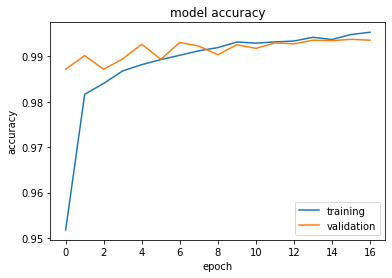

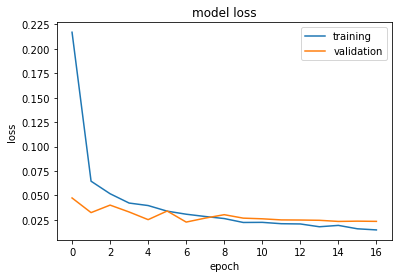

In [105]:
plt.figure(1)
plt.plot(history2_after.history['accuracy'])
plt.plot(history2_after.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

plt.figure(2)
plt.plot(history2_after.history['loss'])
plt.plot(history2_after.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

This is pretty good! It achieves higher accuracy than the LeNet, and in almost half the time.

#### Untrained network with random initializations

In [109]:
model2 = Sequential()

# Lambda Layer for adding Padding
model2.add(Lambda(lambda image: tf.image.resize_with_crop_or_pad(
        image, 28, 28), input_shape=(*IMAGE_SIZE_BEFORE_PADDING, 1)))

# 1st Convolution Layer
model2.add(Conv2D(32, input_shape=(*IMAGE_SIZE, 1), kernel_size=3, activation=mish))
model2.add(BatchNormalization())
model2.add(Conv2D(32, kernel_size=3, activation=mish))
model2.add(BatchNormalization())
model2.add(Conv2D(32, kernel_size=5, strides=2, padding='same', activation=mish))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

# 2nd Convolution Layer
model2.add(Conv2D(64, kernel_size=3, activation=mish))
model2.add(BatchNormalization())
model2.add(Conv2D(64, kernel_size=3, activation=mish))
model2.add(BatchNormalization())
model2.add(Conv2D(64, kernel_size=5, strides=2, padding='same', activation=mish))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

# 3rd Convolution Layer
model2.add(Conv2D(128, kernel_size = 4, activation=mish))
model2.add(BatchNormalization())

# Passing to a Fully Connected Layer
model2.add(Flatten())
model2.add(Dropout(0.4))

# Output Layer

# Increasing the softmax temperature
model2.add(Lambda(lambda x: x / temp))
model2.add(Dense(10, activation='softmax'))

model2.summary()

model2.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_40 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_113 (Bat (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_114 (Bat (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_115 (Bat (None, 12, 12, 32)      

In [110]:
checkpoint_filepath2_un = 'part2_untrained2/checkpoint'
model_checkpoint_callback2_un = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath2_un,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history2_un = model2.fit(
    train_generator3,
    epochs=17,
    validation_data=mnist_test_gen,
    steps_per_epoch = len(x_train) // BATCH_SIZE,
    validation_steps = len(x_test) // BATCH_SIZE,
    callbacks=[model_checkpoint_callback2_un, early_stopping_callback]
)

Epoch 1/17
937/937 [==============================] - 12s 12ms/step - loss: 0.4512 - accuracy: 0.9017 - val_loss: 0.0512 - val_accuracy: 0.9836
Epoch 2/17
937/937 [==============================] - 11s 11ms/step - loss: 0.0633 - accuracy: 0.9817 - val_loss: 0.0342 - val_accuracy: 0.9887
Epoch 3/17
937/937 [==============================] - 11s 11ms/step - loss: 0.0458 - accuracy: 0.9865 - val_loss: 0.0382 - val_accuracy: 0.9879
Epoch 4/17
937/937 [==============================] - 11s 11ms/step - loss: 0.0421 - accuracy: 0.9878 - val_loss: 0.0307 - val_accuracy: 0.9914
Epoch 5/17
937/937 [==============================] - 11s 12ms/step - loss: 0.0341 - accuracy: 0.9899 - val_loss: 0.0321 - val_accuracy: 0.9900
Epoch 6/17
937/937 [==============================] - 11s 11ms/step - loss: 0.0332 - accuracy: 0.9898 - val_loss: 0.0259 - val_accuracy: 0.9917
Epoch 7/17
937/937 [==============================] - 11s 11ms/step - loss: 0.0294 - accuracy: 0.9908 - val_loss: 0.0253 - val_accuracy:

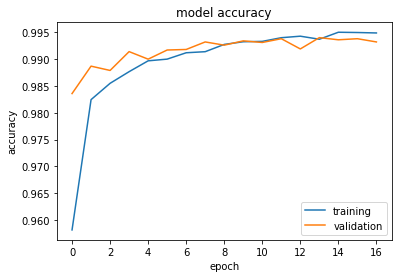

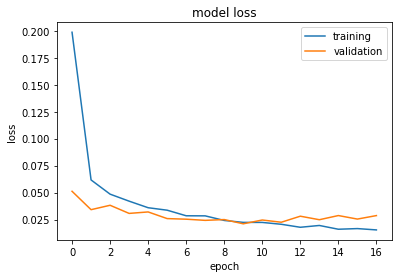

In [111]:
plt.figure(1)
plt.plot(history2_un.history['accuracy'])
plt.plot(history2_un.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

plt.figure(2)
plt.plot(history2_un.history['loss'])
plt.plot(history2_un.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

This performs the same as before. Let's see them together to notice the difference.

#### Observations and results

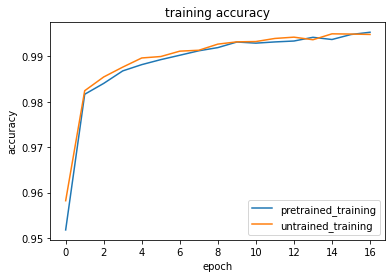

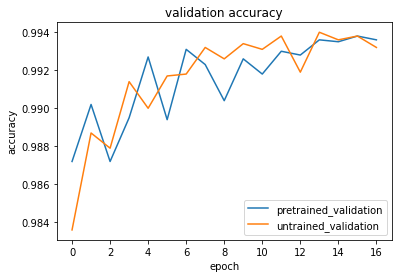

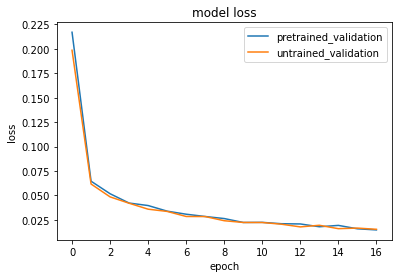

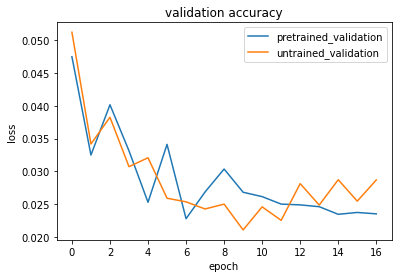

In [112]:
plt.figure(1)
plt.plot(history2_after.history['accuracy'])
plt.plot(history2_un.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['pretrained_training', 'untrained_training'], loc='best')
plt.show()

plt.figure(2)
plt.plot(history2_after.history['val_accuracy'])
plt.plot(history2_un.history['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['pretrained_validation', 'untrained_validation'], loc='best')
plt.show()

plt.figure(3)
plt.plot(history2_after.history['loss'])
plt.plot(history2_un.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['pretrained_validation', 'untrained_validation'], loc='best')
plt.show()

plt.figure(4)
plt.plot(history2_after.history['val_loss'])
plt.plot(history2_un.history['val_loss'])
plt.title('validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['pretrained_validation', 'untrained_validation'], loc='best')
plt.show()

This is interesting. For this case, the untrained model performs 'slightly' better than the pretrained one during the initial epochs but the pretrained model does better in the end.

As seen before, it did not perform well during pre-training. This may be due to the more complex nature of the architecture and less availability of the pretraining data.

It is to be noted that this architecture achieved very good accuracy in almost half the epochs of the original LeNet.

Some observations:
- The untrained accuracy for both the test and validation sets start higher than the pretrianed models.
- During the training phase, the pretrained overall performs better in the end.
- The same can be said for the loss, which starts lower for both the training and validation set for the pretrained model and for most part, stays lower.
- **Overall, the pre-trained network ahs higher final accuracy and lower final loss.**


# Task 2 Part 3

## Extracting the dataset

In [115]:
shutil.unpack_archive('mnistTask3.zip', 'input/part3')

In [117]:
train_datagen3 = ImageDataGenerator(rescale=1./255)

Found 60000 images belonging to 10 classes.
(64, 28, 28, 1) (64, 10)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


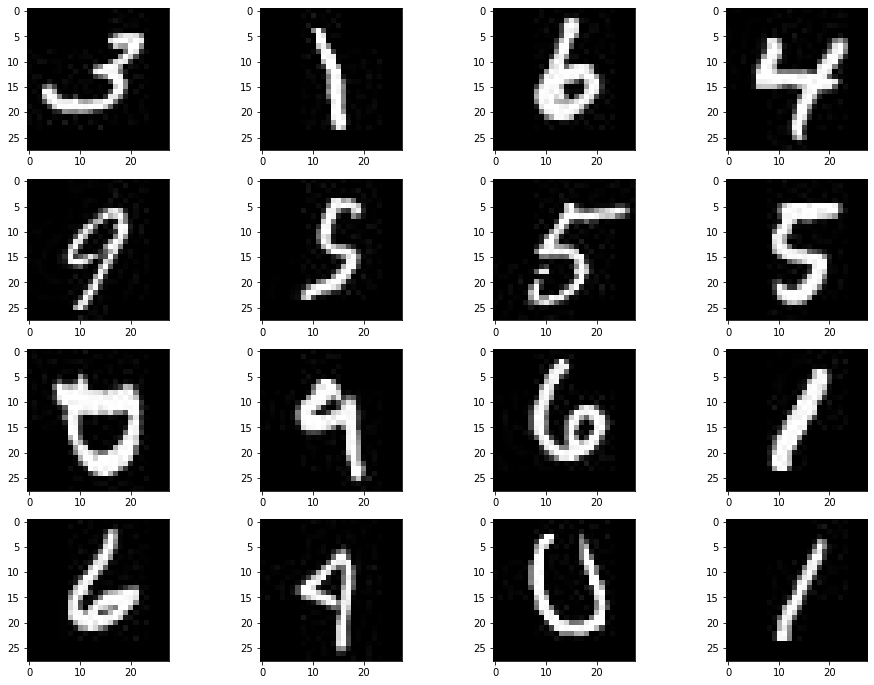

In [118]:
train_generator3 = train_datagen3.flow_from_directory(
    'input/part3/mnistTask',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training',
    seed=42,
    shuffle=True)

X_train_batch3, y_train_batch3 = train_generator3.next()
print(X_train_batch3.shape, y_train_batch3.shape)
print(y_train_batch3[0])
plt.figure(figsize=(16,12))
for i in range(1, 17):
    plt.subplot(4,4,i)
    imshow(tf.squeeze(X_train_batch3[i]), cmap='gray')
plt.show()

## Building the Model

I've used the 2nd Architecture for faster convergence

In [124]:
model3 = Sequential()

# 1st Convolution Layer
model3.add(Conv2D(32, input_shape=(*IMAGE_SIZE, 1), kernel_size=3, activation=mish))
model3.add(BatchNormalization())
model3.add(Conv2D(32, kernel_size=3, activation=mish))
model3.add(BatchNormalization())
model3.add(Conv2D(32, kernel_size=5, strides=2, padding='same', activation=mish))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))

# 2nd Convolution Layer
model3.add(Conv2D(64, kernel_size=3, activation=mish))
model3.add(BatchNormalization())
model3.add(Conv2D(64, kernel_size=3, activation=mish))
model3.add(BatchNormalization())
model3.add(Conv2D(64, kernel_size=5, strides=2, padding='same', activation=mish))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))

# 3rd Convolution Layer
model3.add(Conv2D(128, kernel_size = 4, activation=mish))
model3.add(BatchNormalization())

# Passing to a Fully Connected Layer
model3.add(Flatten())
model3.add(Dropout(0.4))

# Output Layer

# Increasing the softmax temperature
model3.add(Lambda(lambda x: x / temp))
model3.add(Dense(10, activation='softmax'))

model3.summary()

model3.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_134 (Bat (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_135 (Bat (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_136 (Bat (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_60 (Dropout)         (None, 12, 12, 32)      

In [125]:
checkpoint_filepath3 = 'part3/checkpoint'
model_checkpoint_callback3 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath3,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history3 = model3.fit(
    train_generator3,
    epochs=EPOCHS,
    validation_data=mnist_test_gen,
    steps_per_epoch = train_generator3.samples // BATCH_SIZE // BATCH_SIZE,
    validation_steps = len(x_test) // BATCH_SIZE,
    callbacks=[model_checkpoint_callback3, early_stopping_callback2]
)

Epoch 1/400
14/14 [==============================] - 2s 101ms/step - loss: 2.3510 - accuracy: 0.0999 - val_loss: 2.3044 - val_accuracy: 0.0980
Epoch 2/400
14/14 [==============================] - 1s 74ms/step - loss: 2.3570 - accuracy: 0.0996 - val_loss: 2.3115 - val_accuracy: 0.0320
Epoch 3/400
14/14 [==============================] - 1s 75ms/step - loss: 2.3429 - accuracy: 0.1234 - val_loss: 2.3213 - val_accuracy: 0.0281
Epoch 4/400
14/14 [==============================] - 1s 76ms/step - loss: 2.3446 - accuracy: 0.1220 - val_loss: 2.3289 - val_accuracy: 0.0449
Epoch 5/400
14/14 [==============================] - 1s 77ms/step - loss: 2.3509 - accuracy: 0.1131 - val_loss: 2.3544 - val_accuracy: 0.0759
Epoch 6/400
14/14 [==============================] - 1s 74ms/step - loss: 2.3196 - accuracy: 0.0975 - val_loss: 2.3816 - val_accuracy: 0.0830
Epoch 7/400
14/14 [==============================] - 1s 74ms/step - loss: 2.3376 - accuracy: 0.1117 - val_loss: 2.4043 - val_accuracy: 0.0136
Epoch

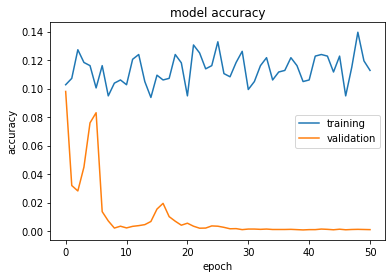

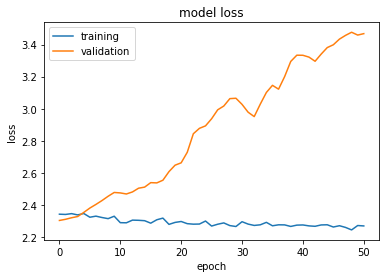

In [126]:
plt.figure(1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

plt.figure(2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

I've used higher early stopping patience level for this as this had so much variance.



### Observation and results

This model does not perform any good. This is because of the data provided, as we have seen pretty good results with this model.

I think this dataset comes from the MNIST distribution, but has been randomly shiuffled, so the labels no more correspond to the correct image. SInce this was tested on the correctly labelled MNIST dataset, it performed very badly as it had learned the wrong weights.

This is a classic example of how we should alwasy check and verify that the data that we have is cleaned, properly labelled and unbiased as even good models give very bad and biased predictions if the data is incorrect.